In [1]:
import pickle
import pykitti
import pydriver
import pypcd
import faiss
import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Reading the drive cloud

In [2]:
def read_clouds(basedir='KITTI', date='2011_09_26', drive='0035'):
    data = pykitti.raw(basedir, date, drive, frames=range(60, 70))
    for cloud in data.velo:
        yield cloud[:,:3]

In [3]:
cloud_gen = read_clouds()

def create_cloud(data):
    cloud = pydriver.pcl.pcl.PCLHelper()
    cloud.fromArray(data)
    return cloud


cl1_data, cl2_data = next(cloud_gen), next(cloud_gen)
cloud_1 = create_cloud(cl1_data)
cloud_2 = create_cloud(cl2_data)

In [4]:
cl1_data.shape

(114358, 3)

In [5]:
cl2_data.shape

(114632, 3)

### Extracting the keypoints

In [6]:
def extractSHOT(cloud, shotRadius=1.5):
    extractor = pydriver.features.shot.SHOTExtractor(shotRadius=shotRadius)
    return extractor.getFeatures({'cloud': cloud}, cloud)

In [7]:
%%time
feats1 = extractSHOT(cloud_1)

CPU times: user 47.5 s, sys: 224 ms, total: 47.8 s
Wall time: 11.1 s


In [8]:
%%time
feats2 = extractSHOT(cloud_2)

CPU times: user 47.5 s, sys: 216 ms, total: 47.7 s
Wall time: 11.5 s


In [9]:
%%time
cloud_1 = create_cloud(np.array([list(line) for line in feats1[0]]))
cloud_2 = create_cloud(np.array([list(line) for line in feats2[0]]))

CPU times: user 456 ms, sys: 20.1 ms, total: 476 ms
Wall time: 475 ms


In [10]:
feats1 = feats1[1].astype(np.float32)
feats2 = feats2[1].astype(np.float32)

### Matching the keypoints (kNN - FAISS-implementation)

In [13]:
%%time

# Building the index
nlist = int(np.sqrt(feats2.shape[0]))
d = feats2.shape[-1]
quantizer = faiss.IndexFlatL2(d)   # build the index
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

CPU times: user 41 µs, sys: 7 µs, total: 48 µs
Wall time: 49.6 µs


In [14]:
%%time
index.train(feats2)
assert index.is_trained
index.add(feats2)

CPU times: user 38.5 s, sys: 24.2 s, total: 1min 2s
Wall time: 8.02 s


In [15]:
%%time

# Performing kNN
distances = []
indices = []
n_threads = 8
for i in tqdm.tqdm_notebook(range((feats1.shape[0] + n_threads - 1) // n_threads)):
    start, end = i * n_threads, (i + 1) * n_threads
    query = feats1[start:end]
    D, I = index.search(query, 1)
    distances += list(D.ravel())
    indices += list(I.ravel())


CPU times: user 10.5 s, sys: 2.98 ms, total: 10.5 s
Wall time: 1.36 s


In [16]:
assert len(distances) == len(feats1)
assert len(indices) == len(feats1)

In [17]:
indices[:5]

[3, 4, 4, 41000, 8]

In [18]:
distances[:5]

[0.09013024, 0.0716871, 0.18087459, 0.66395855, 0.30887198]

### Setting the optimal threshold for kNN

In [310]:
kNN_THRESHOLD = 0.05

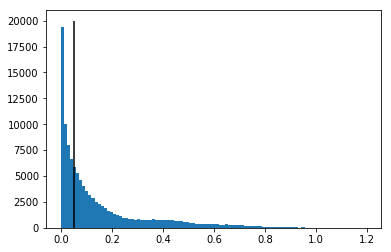

In [311]:
plt.hist(distances, bins=100)
plt.vlines(kNN_THRESHOLD, 0, 20000, colors='black')
plt.show()

### Making matches

In [312]:
%%time
kp_set_1 = set(np.arange(len(feats1)))
kp_set_2 = set(np.arange(len(feats2)))

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.4 ms


In [313]:
%%time
matches = []

# Sampling uniform indices is the same as random shuffling them at the beginning
indices = np.arange(len(kp_set_1))
np.random.seed(42)
np.random.shuffle(indices)
for idx in tqdm.tqdm(indices):
    if distances[idx] <= kNN_THRESHOLD and indices[idx] in kp_set_2:
        matches.append((idx, indices[idx]))
        kp_set_2.remove(indices[idx])

100%|██████████| 114163/114163 [00:00<00:00, 633986.73it/s]

CPU times: user 190 ms, sys: 6 µs, total: 190 ms
Wall time: 189 ms


In [314]:
len(matches)

45008

In [315]:
matches[:5]

[(97615, 40403), (75031, 42612), (52366, 1498), (92157, 22505), (75252, 22365)]

### Making triangulation

In [319]:
cloud_1.save('/home/shakhrayv/Documents/mipt/thesis/3D-Scene-Flow-Optimization/frames/frame.pcd')

In [320]:
!./triangulation/extract_mesh frames/frame.pcd

### (Optional) visualization

In [ ]:
!./visualization/visualize_mesh mesh.vtk

### Reading triangulation data

In [321]:
f = open('mesh.vtk', 'r')

In [322]:
def skip_block(n):
    for _ in range(n):
        f.readline()

In [323]:
skip_block(4)
    
header = f.readline()

In [324]:
n_points = int(header.strip().split()[1])
points = [tuple(map(float, f.readline().strip().split())) for i in range(n_points)]
skip_block(n_points + 3)

In [325]:
polygons = []
n_polygons = int(f.readline().strip().split()[1])
for i in range(n_polygons):
    polygons.append(tuple(map(int, f.readline().strip().split()))[1:])

In [326]:
len(polygons)

1923

### Solving the energy minimization problem

In [327]:
from pyquaternion import Quaternion

In [328]:
def vector2tq(vector):
    translation = vector[:3]
    vector_part = vector[3:]
    rotation = Quaternion(1, *vector_part)
    return translation, rotation

In [329]:
def transform(vector, translation, rotation):
    return rotation.rotate(vector) + translation

In [356]:
def data_term_error(p, p_, tau):
    t, q = vector2tq(tau)
    result = transform(p, t, q)
    return np.linalg.norm(result - p_)

# Required for scipy.optimize.root method
def create_data_func(p, p_):
    def func(tau):
        return data_term_error(p, p_, tau)
    return func

In [331]:
def regularization_term(tau_1, tau_2):
    t1, q1 = vector2tq(tau_1)
    t2, q2 = vector2tq(tau_2)
    mat1 = q1.rotation_matrix
    mat2 = q2.rotation_matrix
    # building SE3 matrices
    mat1 = np.hstack([mat1, t1.reshape((-1, 1))])
    mat2 = np.hstack([mat2, t2.reshape((-1, 1))])
    mat1 = np.vstack([mat1, np.array([0, 0, 0, 1])])
    mat2 = np.vstack([mat2, np.array([0, 0, 0, 1])])
    product = np.linalg.inv(mat1) @ mat2
    translation = product[:3,3].ravel()
    vector = Quaternion(matrix=product[:3,:3]).vector.ravel()
    result = np.zeros(6)
    result[:3] = translation
    result[3:] = vector
    return np.linalg.norm(result)

### Checking some distributions

In [332]:
len(matches)

45008

In [333]:
len(polygons)

1923

In [334]:
match = dict(matches)

In [335]:
poly = [set() for _ in range(len(feats1))]
for i, polygon in enumerate(polygons):
    for dot in polygon:
        poly[dot].add(i)

In [336]:
# Calculating statistics
no_connections = 0 # Not the keypoint, not in any triangle
keypoint_only = 0 # Not in any triangle, but is a keypoint
only_triangle = 0 # Not the keypoint, but in a triange
keypoint_triangle = 0 # Is a keypoint, is a triangle
for index in range(len(feats1)):
    if index not in match:
        if len(poly[index]) == 0:
            no_connections += 1
        else:
            only_triangle += 1
    else:
        if len(poly[index]) == 0:
            keypoint_only += 1
        else:
            keypoint_triangle += 1

In [337]:
no_connections, keypoint_only, only_triangle, keypoint_triangle

(67342, 43154, 1813, 1854)

Checking, how many triangles are isolated (important!)

In [338]:
num_isolated = 0
for p in polygons:
    isolated = True
    for d in p:
        assert len(poly[d]) >= 1
        if len(poly[d]) > 1:
            isolated = False
            break
    if isolated:
        num_isolated += 1
num_isolated

647

### Solving only for keypoints

An example first

In [373]:
key = list(match.keys())[1]

In [374]:
i1, i2 = key, match[key]

In [375]:
p1, p2 = cloud_1.toArray(True, False)[i1], cloud_2.toArray(True, False)[i2]

In [376]:
p1, p2

(array([ 3.117     , -0.496     ,  0.17400658], dtype=float32),
 array([ -0.989, -10.801,  -0.468], dtype=float32))

In [377]:
# This is what the answer should look like! 
p2 - p1

array([ -4.106    , -10.304999 ,  -0.6420066], dtype=float32)

In [378]:
vector = np.random.randn(6)

In [380]:
from scipy.optimize import root

In [381]:
f = create_data_func(p1, p2)

In [382]:
f(np.random.randn(6))

10.282414226698046

In [385]:
import scipy
scipy.optimize.minimize(f, [1, 1, 1, 0, 0, 0], method='Nelder-Mead')

 final_simplex: (array([[-4.14582814e+00, -1.06479335e+01, -5.23530714e-01,
        -7.60863744e-03,  1.96769128e-02,  5.43794335e-02],
       [-4.14583284e+00, -1.06478624e+01, -5.23483046e-01,
        -7.60841828e-03,  1.96768064e-02,  5.43786635e-02],
       [-4.14576720e+00, -1.06479420e+01, -5.23496184e-01,
        -7.60869527e-03,  1.96769798e-02,  5.43791658e-02],
       [-4.14578672e+00, -1.06479203e+01, -5.23443214e-01,
        -7.60861920e-03,  1.96770432e-02,  5.43785064e-02],
       [-4.14576113e+00, -1.06478995e+01, -5.23524636e-01,
        -7.60874181e-03,  1.96768819e-02,  5.43793069e-02],
       [-4.14583537e+00, -1.06479666e+01, -5.23526332e-01,
        -7.60869923e-03,  1.96770110e-02,  5.43795677e-02],
       [-4.14587811e+00, -1.06478685e+01, -5.23505455e-01,
        -7.60837011e-03,  1.96767993e-02,  5.43788767e-02]]), array([4.34134677e-05, 5.10282752e-05, 5.54898491e-05, 5.97715040e-05,
       6.03343010e-05, 6.57253812e-05, 7.71560455e-05]))
           fun: 4.34

### Solving for the triangles

In [393]:
p = polygons[0]

In [394]:
p1, p2, p3 = cloud_1.toArray(True, False)[p[0]], cloud_1.toArray(True, False)[p[1]], cloud_1.toArray(True, False)[p[2]]

In [395]:
p1, p2, p3

(array([ 1.5720457, -0.872    , -4.305    ], dtype=float32),
 array([ 1.5805758, -0.863    , -4.306    ], dtype=float32),
 array([ 1.5781583, -0.85     , -4.298    ], dtype=float32))

In [401]:
def metric_function(vec):
    taus = vec[:6], vec[6:12], vec[12:]
    metric = 0.
    
    # Adding data term
    for i in range(3):
        if p[i] in match:
            metric += data_term_error(cloud_1.toArray(True, False)[p[i]], cloud_2.toArray(True, False)[match[p[i]]], taus[i])
    
    # Adding regularization
    metric += regularization_term(taus[0], taus[1])
    metric += regularization_term(taus[0], taus[2])
    metric += regularization_term(taus[1], taus[2])
    
    return metric

In [404]:
metric_function(np.random.randn(18))

44.42544804714355

In [406]:
%%time
scipy.optimize.minimize(metric_function, np.random.randn(18), method='Nelder-Mead')

CPU times: user 20.6 s, sys: 28.5 s, total: 49.1 s
Wall time: 12.3 s


 final_simplex: (array([[   0.50410984,    0.92426357,   33.17808521,   76.76177242,
          -7.81766253,   22.90983098,    0.60071217,    1.11030675,
          33.20138264,   -0.35290197,  -26.99710395,  -20.0310533 ,
           0.63011843,    1.182036  ,   33.20668546,  -12.33754848,
        -123.90325097,  -34.50084871],
       [   0.50405032,    0.92426927,   33.17806672,   76.76151787,
          -7.81762348,   22.90916133,    0.60067366,    1.1103307 ,
          33.20159119,   -0.35243082,  -26.99702537,  -20.03057454,
           0.63011609,    1.18201017,   33.20675983,  -12.33750431,
        -123.90217482,  -34.50067494],
       [   0.50418717,    0.92426016,   33.17809726,   76.76252482,
          -7.81774822,   22.91075313,    0.60058939,    1.11024325,
          33.20130705,   -0.35348356,  -26.99709574,  -20.03169752,
           0.63012679,    1.18207102,   33.20641886,  -12.33765222,
        -123.90519936,  -34.50104384],
       [   0.50377801,    0.9242967 ,   33.1780193